In [1]:
import pandas
import re
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import InputLayer, Masking, LSTM, TimeDistributed, Dense
from math import ceil
from keras.callbacks import Callback, ModelCheckpoint

Using TensorFlow backend.


# Minimal State LSTM Simulation

## Overview

The goal of this notebook is to use 2017 Ford F-150 Ecoboost chasis dynamometer data from the Argonne National Laboratory to simulate the speed of the vehicle given the current brake pedal and accelerator pedal pressures. The model tested in this notebook is a sequence-to-sequence LSTM. Note that the model is end-to-end, not an encoder-decoder model. Furthermore, *only* the brake and accelerator pedal positions are used as input features. Hopefully the LSTM can store all other important information internally and implicitly. If not, we can employ teacher forcing and store more state information externally to help the LSTM.

## Data

This data is from the Downloadable Dynamometer Database and was generated at the Advanced Mobility Technology Laboratory (AMTL) at Argonne National Laboratory under the funding and guidance of the U.S. Department of Energy (DOE).

First, load a list of TSV data files. These individual files represent separate tests done on the vehicle. Each have different goals and simulation techniques which you can read about in the `./Dynamometer/2017 Ford F150 Ecoboost Test Summary.xlsx` file. The data is recorded at the frequency of 10Hz.

In [2]:
csvs = list(filter(lambda file: re.match(r'^\d{8} Test Data\.txt$', file) is not None, os.listdir('./DynamometerData')))

We load each TSV into a Pandas dataframe. Note: you may not have enough memory to do this all in one pass. If so, load each individual TSV and only keep the important columns identified below.

In [3]:
dfs = [pandas.read_csv('./DynamometerData/' + csv, sep='\t', header=0) for csv in csvs]

We can get an idea of which columns we have access to. We are looking for columns recording accelerator pedal position, break pedal position, and resulting speed.

In [4]:
list(dfs[0].columns)

['Time[s]_RawFacilities',
 'Dyno_Spd[mph]',
 'Dyno_TractiveForce[N]',
 'Dyno_LoadCell[N]',
 'Distance[mi]',
 'Dyno_Spd_Front[mph]',
 'Dyno_TractiveForce_Front[N]',
 'Dyno_LoadCell_Front[N]',
 'Dyno_Spd_Rear[mph]',
 'Dyno_LoadCell_Rear[N]',
 'Dyno_TractiveForce_Rear[N]',
 'DilAir_RH[%]',
 'Tailpipe_Press[inH2O]',
 'Cell_Temp[C]',
 'Cell_RH[%]',
 'Cell_Press[inHg]',
 'Tire_Front_Temp[C]',
 'Tire_Rear_Temp[C]',
 'Drive_Trace_Schedule[mph]',
 'Exhaust_Bag',
 'Engine_Oil_Dipstick_Temp[C]',
 'Radiator_Air_Outlet_Temp[C]',
 'Engine_Bay_Temp[C]',
 'Cabin_Temp[C]',
 'Cabin_Upper_Vent_Temp[C]',
 'Cabin_Lower_Vent_Temp[C]',
 'Solar_Array_Ind_Temp[C]',
 'Eng_FuelFlow_Direct2[gps]',
 '12VBatt_Volt_Hioki_U1[V]',
 '12VBatt_Curr_Hioki_I1[A]',
 '12VBatt_Power_Hioki_P1[W]',
 'Alternator_Curr_Hioki_I2[A]',
 'Alternator_Power_Hioki_P2[W]',
 '12VBatt_Curr_Hi_Hioki_I3[A]',
 '12VBatt_Power_Hi_Hioki_P3[W]',
 'Eng_FuelFlow_Direct[ccps]',
 'Eng_Fuel_Temp_Direct[C]',
 'Time[s]',
 'Trans_shift_inprogress_CAN[]',


Before we select our columns, we need to know the maximum sequence recorded. We will round to the nearest 100 to allow for flexible batch sizes.

In [5]:
max_length = (ceil(max([len(df) for df in dfs]) / 100)) * 100
max_length

61600

Now we can convert the data frames into input and target sets of sequences.

In [6]:
X = np.zeros([len(dfs), max_length, 2])
Y = np.zeros([len(dfs), max_length, 1])

for i, df in enumerate(dfs):

    # One sequence doesn't have this column as the break is never touched
    if 'Brake_pressure_applied_PCM[]' in df.columns:
        X[i,:len(df),0] += df['Brake_pressure_applied_PCM[]'].values
    X[i,:len(df),1] += df['Pedal_accel_pos_CAN[per]'].values
    
    Y[i,:len(df),0] += df['Dyno_Spd[mph]'].values

We can now delete the data frames to force release of some memory.

In [7]:
del dfs

We can plot a few sequences to get a feel for the data.

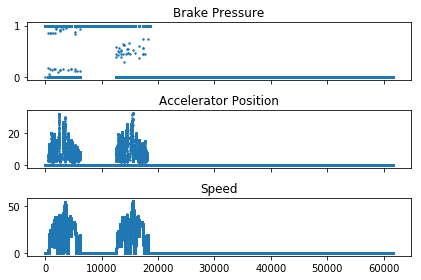

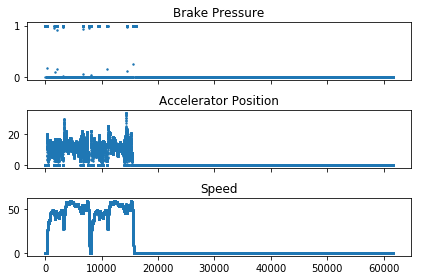

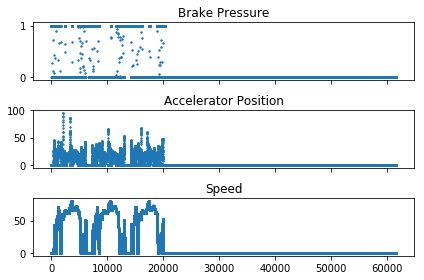

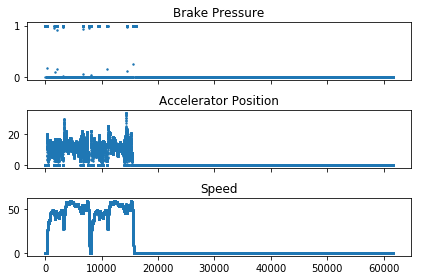

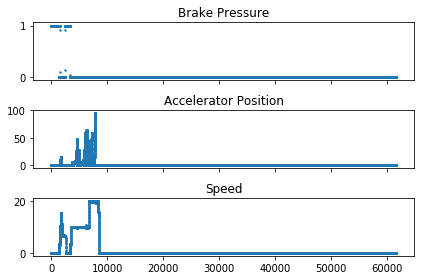

In [8]:
for _ in range(5):
    
    i = np.random.randint(0, X.shape[0])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    
    ax1.scatter(range(max_length), X[i,:,0], s=2)
    ax1.set_title('Brake Pressure')

    ax2.scatter(range(max_length), X[i,:,1], s=2)
    ax2.set_title('Accelerator Position')
    
    ax3.scatter(range(max_length), Y[i,:,0], s=2)
    ax3.set_title('Speed')

    plt.tight_layout()
    plt.show()

Because the LSTM network is sensitive to magnitude, we need to scale our data. Since the sigmoid activation is used, we scale to the range $[0, 1]$. We store the minimums and maximums to inverse the transform after training and testing.

In [9]:
X_std = np.zeros(X.shape)
Y_std = np.zeros(Y.shape)

X0_min, X0_max = X[:,:,0].min(), X[:,:,0].max()
X1_min, X1_max = X[:,:,1].min(), X[:,:,1].max()
Y0_min, Y0_max = Y[:,:,0].min(), Y[:,:,0].max()

X_std[:,:,0] += (X[:,:,0] - X0_min) / (X0_max - X0_min)
X_std[:,:,1] += (X[:,:,1] - X1_min) / (X1_max - X1_min)
Y_std[:,:,0] += (Y[:,:,0] - Y0_min) / (Y0_max - Y0_min)

We plot a few again to make sure the data is scaled properly.

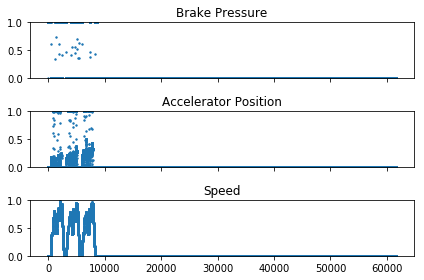

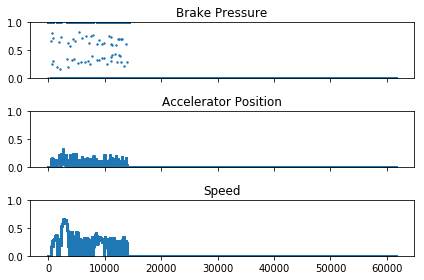

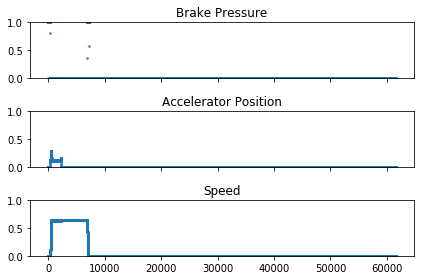

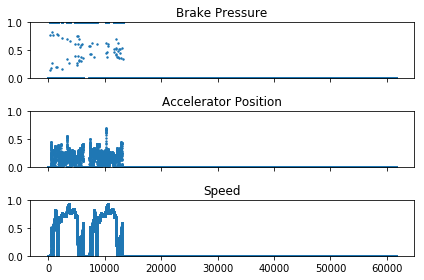

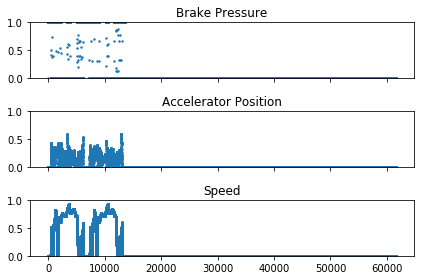

In [10]:
for _ in range(5):
    
    i = np.random.randint(0, X.shape[0])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    
    ax1.scatter(range(max_length), X_std[i,:,0], s=2)
    ax1.set_title('Brake Pressure')
    ax1.set_ylim(0, 1)

    ax2.scatter(range(max_length), X_std[i,:,1], s=2)
    ax2.set_title('Accelerator Position')
    ax2.set_ylim(0, 1)
    
    ax3.scatter(range(max_length), Y_std[i,:,0], s=2)
    ax3.set_title('Speed')
    ax3.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

## Model

We are now ready to start developing a model for our sequence. Since our sequences are one-to-one, I will not bother with an encoder-decoder architecture yet. This aslo shouldn't be necessary as only the past data is necessary to predict a single element of the sequence.

Since our sequences are over 60,000 elements long, we are going to use a trick to divide the sequences into 100-element subsequences and use the `stateful` parameter in our LSTM layer. The `stateful` option will store and pass along the state of the LSTM between batches. In other words, the terminating state of the $i$th sequence in the batch will be the initial state of the $i$th sequence in the following batch. 

This means we have to be very careful when defining our inputs. Typically, the `batch_input_shape` is of the form `(batch_size, time_steps, features)`. However, we are not batching on the first axis of our data (the individual sequences) but the length of the sequence. So, our `batch_input_shape` will follow the form `(n_samples, batch_length, features)`. We have 95 sequences, and we will save 10\% to use as test sequences, our number of samples for training is 86. And, as stated before, the length of the subsequences will be 100 elements.

The `return_sequences` option will override the typical LSTM behavior of just returning the last output as we want to use the entire sequence. The `stateful` option is discussed above.

The output layer is a `TimeDistributed` `Dense` layer. This will apply the `linear` activation to every element in the output sequence from the LSTM.

In [11]:
train_model = Sequential()

train_model.add(InputLayer(batch_input_shape=(86, 100, X.shape[2])))
train_model.add(LSTM(200, return_sequences=True, stateful=True))
train_model.add(TimeDistributed(Dense(Y.shape[2], activation='linear')))

train_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (86, 100, 200)            162400    
_________________________________________________________________
time_distributed_1 (TimeDist (86, 100, 1)              201       
Total params: 162,601
Trainable params: 162,601
Non-trainable params: 0
_________________________________________________________________


`RMSprop` is recommended for LSTM sequences and `mean_squared_error` is appropriate for our numeric output.

In [12]:
train_model.compile(optimizer='RMSprop', loss='mse')

## Training

Because of out slightly unusual batching strategy, we need to implement a custom generator. We could extend a `keras.layers.Sequential` class, but our batching strategy is not too unusual so it is easy enough to implement a Python generator. The infinite loop allows for variable length epochs.

In [13]:
def batch_generator(X, y, batch_size):
    while True:
        for i in range(0, X.shape[1], batch_size):        
            yield (X[:,i:i+batch_size,:], y[:,i:i+batch_size,:])

Because our batch size is fixed, it is not possible to do simultaneous training and validation (unless we halved our data). So, here we manually shuffle and split our data using a 90-10 split.

In [14]:
SPLIT = X_std.shape[0] - X_std.shape[0] // 10

indices = np.arange(0, X_std.shape[0])
np.random.shuffle(indices)

X_shuffled = X_std[indices,:,:]
Y_shuffled = Y_std[indices,:,:]

X_train, X_test = X_shuffled[:SPLIT,:,:], X_shuffled[SPLIT:,:,:]
Y_train, Y_test = Y_shuffled[:SPLIT,:,:], Y_shuffled[SPLIT:,:,:]

It is very important to realize that Keras does not reset the state in a stateful LSTM after each epoch. However, we do *not* want the state to carry over between epochs. Therefore, we manually reset after each epoch using a custom callback.

In [15]:
class ResetStates(Callback):
  
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()

In [16]:
reset_states = ResetStates()

Because we are in a notebook and we don't want to lose our model upon a disconnect, we will use the `ModelCheckpoint` callback to save the best model seen so far.

In [17]:
model_checkpoint = ModelCheckpoint('./Models/MinimalStateLSTM/E{epoch:03d}L{loss:06.4E}.hdf5', save_weights_only=True)

Now we are ready to train. We will run for 200 epochs. Note that `steps_per_epoch` is required because our generator has no length. This is the max sequence length divided by the batch length.

In [ ]:
train_model.fit_generator(batch_generator(X_train, Y_train, 100), epochs=200, steps_per_epoch=X.shape[1] / 100, callbacks=[reset_states, model_checkpoint])

## Testing

Our model above was specifically designed for training with fixed sequence lengths and batch sizes. We can define a new model for testing with a more flexible input shape.

In [18]:
test_model = Sequential()

test_model.add(InputLayer(input_shape=(None, X.shape[2])))
test_model.add(LSTM(200, return_sequences=True))
test_model.add(TimeDistributed(Dense(Y.shape[2], activation='linear')))

Then, we can copy the weights from our trained models to run some predictions. 

### Initial

We will start with the first epoch to see how the LSTM progressed over all epochs.

In [19]:
test_model.load_weights('Models/MinimalStateLSTM/E001L1.7364E-02.hdf5')

We choose a random sequence predict and validate the model.

In [20]:
i = np.random.randint(0, 9)
Y_pred = test_model.predict(X_test[i:i+1,:,:], batch_size=1)

And plot the result to see what our model is doing.

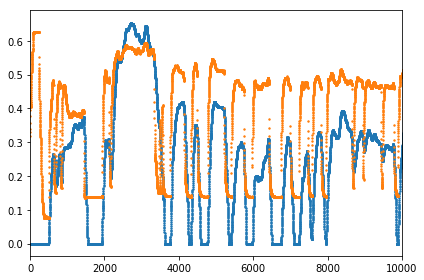

In [21]:
fig, ax = plt.subplots()

ax.scatter(range(max_length), Y_test[i,:,0], s=2)
ax.scatter(range(max_length), Y_pred[0,:,0], s=2)

# Zoom in
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()

It might also help to see the output in context with the input features.

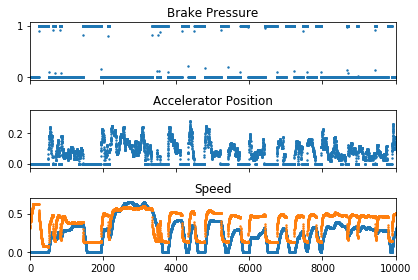

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.scatter(range(max_length), X_test[i,:,0], s=2)
ax1.set_title('Brake Pressure')

ax2.scatter(range(max_length), X_test[i,:,1], s=2)
ax2.set_title('Accelerator Position')

ax3.scatter(range(max_length), Y_test[i,:,0], s=2)
ax3.set_title('Speed')

ax3.scatter(range(max_length), Y_pred[0,:,0], s=2)
ax3.set_title('Speed')

# Zoom in
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()

### Final

We repeat the process for the final epoch to see the improvement.

In [23]:
test_model.load_weights('Models/MinimalStateLSTM/E200L1.9497E-02.hdf5')

We choose a random sequence predict and validate the model.

In [24]:
i = np.random.randint(0, 9)
Y_pred = test_model.predict(X_test[i:i+1,:,:], batch_size=1)

And plot the result to see what our model is doing.

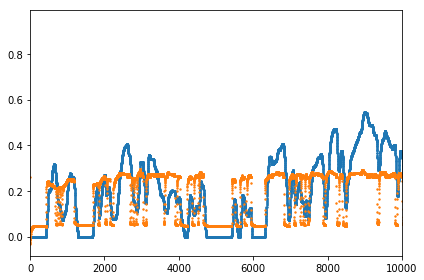

In [25]:
fig, ax = plt.subplots()

ax.scatter(range(max_length), Y_test[i,:,0], s=2)
ax.scatter(range(max_length), Y_pred[0,:,0], s=2)

# Zoom in
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()

It might also help to see the output in context with the input features.

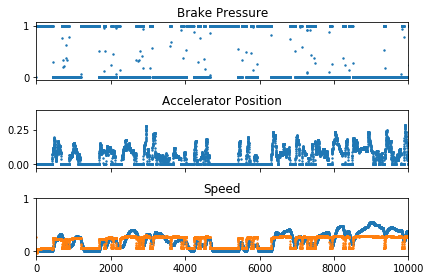

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.scatter(range(max_length), X_test[i,:,0], s=2)
ax1.set_title('Brake Pressure')

ax2.scatter(range(max_length), X_test[i,:,1], s=2)
ax2.set_title('Accelerator Position')

ax3.scatter(range(max_length), Y_test[i,:,0], s=2)
ax3.set_title('Speed')

ax3.scatter(range(max_length), Y_pred[0,:,0], s=2)
ax3.set_title('Speed')

# Zoom in
plt.xlim(0, 10000)

plt.tight_layout()
plt.show()

It doesn't look like the model improved much. If anything, it got worse. I have a few suspicions (aside from overfitting):

- The model is not aware that a sequence has ended. As a result, the loss inflicted by the padded suffix is messing with the learning process.
- The model is pretty good at determining the changes in speed, but is not good at deciding what the resulting speed's magnitude should be.

I will attempt to address the second issue in the notebook `MediumStateLSTM.ipynb` by including the previous speed as an input feature. To address the first issue is a little more difficult as masking is required. However, given our setup with variable sequence lengths, masking would only be affective if batches only included a single sequence. This would greatly slow the learning process.